# LBH to Electron Total Energy Flux Model Predictions

This is the script I used to check my neural network results

In [1]:
import numpy as np
import h5py 
import os
import matplotlib.pyplot as pp
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import pickle
from geospacepy.special_datetime import (jd2datetime,
                                         jdarr2datetime)
from nasaomnireader import omnireader 
from ssj_auroral_boundary.dmsp_spectrogram import dmsp_spectrogram


Traceback (most recent call last):
  File "/home/matsuo/amgeo_dev/AMGeO/src/nasaomnireader/nasaomnireader/__init__.py", line 5, in <module>
    from nasaomnireader.omnireader_config import config
ModuleNotFoundError: No module named 'nasaomnireader.omnireader_config'

Solar wind data files will be saved to /home/matsuo/.local/share/nasaomnireader


## Get the Conjunction data

In [2]:
#read in the conjunction files and save as variables
with h5py.File('model2_inputs.h5','r') as f:
    for key in f:
        print(key)
        exec(key + " = f[key][:]")    

X
ele_diff_energy_flux_arr
ele_flux
ele_flux_smoothed
ion_flux
ion_flux_smoothed
jds
lats
lons
passes
sat_nums
ssusi_lbhl
ssusi_lbhs
y


## Load the model and scalers

In [3]:
model = keras.models.load_model('lbh_ion_mask_to_ele_flux_3')

#get scalers for model
scaler_x = pickle.load(open('X_scaler2.pkl','rb'))
scaler_y = pickle.load(open('Y_scaler2.pkl','rb'))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


## Get the old test train split


In [5]:
unique_passes = np.unique(passes)
len(unique_passes)
test_pass_nums = [ 12.,  18.,  22.,  35.,  51.,  70.,  72.,  83.,  88.,  91., 112.,
       113., 135., 137., 150., 158., 161., 168., 184., 189., 205., 208.,
       216., 217., 222., 228., 240., 244., 261., 263., 267., 272., 274.,
       275., 277., 285., 306., 316., 318., 323., 337., 348., 359., 372.,
       387., 395., 416., 420., 428., 436., 466., 481., 513., 520., 538.,
       555., 566.]

In [6]:
test_mask = np.zeros_like(passes, dtype = bool)
for pass_ind in test_pass_nums:
    test_mask = np.logical_or(test_mask, passes == pass_ind)
    
train_mask = np.logical_not(test_mask)

test_passes = passes[test_mask]
test_pass_nums = np.unique(test_passes)

### Apply the split

In [7]:
y_test, y_train = y[test_mask], y[train_mask]
X_test, X_train = X[test_mask], X[train_mask]
jd_test = jds[test_mask] 
sat_nums_test = sat_nums[test_mask]


#auxiliary things 
ele_diff_energy_flux_test = ele_diff_energy_flux_arr[test_mask.flatten(),:]

#add lat lon
lats_test, lons_test = lats[test_mask], lons[test_mask]
# ion_more_ele_test = ion_more_ele[test_mask]


## Model Prediction

In [8]:
y_predict = model.predict(X_test)

Convert output back to original units

In [9]:
#scale back to Radiance
y_test = scaler_y.inverse_transform(y_test)
y_predict = scaler_y.inverse_transform(y_predict)

#scale back to original units
X_test = scaler_x.inverse_transform(X_test)

## Statistics

Get the median AE for each pass 

In [10]:
startjd, endjd = np.nanmin(jds), np.nanmax(jds)
startdt, enddt = jd2datetime(startjd), jd2datetime(endjd)
omniInt = omnireader.omni_interval(startdt,enddt,'5min')
omni_dt_arr = omniInt['Epoch']
AEs = omniInt['AE_INDEX']

AEs_for_test_passes = np.zeros_like(test_passes)
for test_pass_num in test_pass_nums:
    test_pass_mask = test_pass_num == test_passes
    y_predict_pass, y_test_pass, jd_pass = y_predict[test_pass_mask], y_test[test_pass_mask], jd_test[test_pass_mask]
    
    startdt, enddt = jd2datetime(np.nanmin(jd_pass)),jd2datetime(np.nanmax(jd_pass))
    datetime_mask = np.logical_and(omni_dt_arr < enddt, omni_dt_arr > startdt)

    AE_for_pass = np.nanmedian(AEs[datetime_mask])
    AEs_for_test_passes[test_pass_mask] = AE_for_pass*np.ones_like(y_test_pass.flatten())

Created interval between 2014-02-17 and 2014-02-23, cadence 5min, start index 4610, end index 6624


### Correlations

In [11]:
small_AE_mask = AEs_for_test_passes < 450
big_AE_mask = np.logical_not(small_AE_mask)

print('Correlations for All Test Passes')
print(np.corrcoef(y_test.flatten(),y_predict.flatten())[0,1])
print('Correlations for AE < 450 Test Passes')
print(np.corrcoef(y_test.flatten()[small_AE_mask],y_predict.flatten()[small_AE_mask])[0,1])
print('Correlations for AE > 450 Test Passes')
print(np.corrcoef(y_test.flatten()[big_AE_mask],y_predict.flatten()[big_AE_mask])[0,1])

Correlations for All Test Passes
0.7082939060143305
Correlations for AE < 450 Test Passes
0.6244599642545666
Correlations for AE > 450 Test Passes
0.7411987211318195


### RMSE

In [12]:
print('RMSE for All Test Passes')
print(np.sqrt(mean_squared_error(y_test.flatten(),y_predict.flatten())))
print('RMSE for AE < 450 Test Passes')
print(np.sqrt(mean_squared_error(y_test.flatten()[small_AE_mask],y_predict.flatten()[small_AE_mask])))
print('RMSE for AE > 450 Test Passes')
print(np.sqrt(mean_squared_error(y_test.flatten()[big_AE_mask],y_predict.flatten()[big_AE_mask])))


RMSE for All Test Passes
318279600000.0
RMSE for AE < 450 Test Passes
222050760000.0
RMSE for AE > 450 Test Passes
568329800000.0


## Plot the test passes

275.0
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)
(1328,)


/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:111: RuntimeWarning: invalid value encountered in less
  inds = np.nonzero((~np.isfinite(flux)) | (flux < 0.))
/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:126: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
  cmap.set_bad('white',.1)
/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:127: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap(

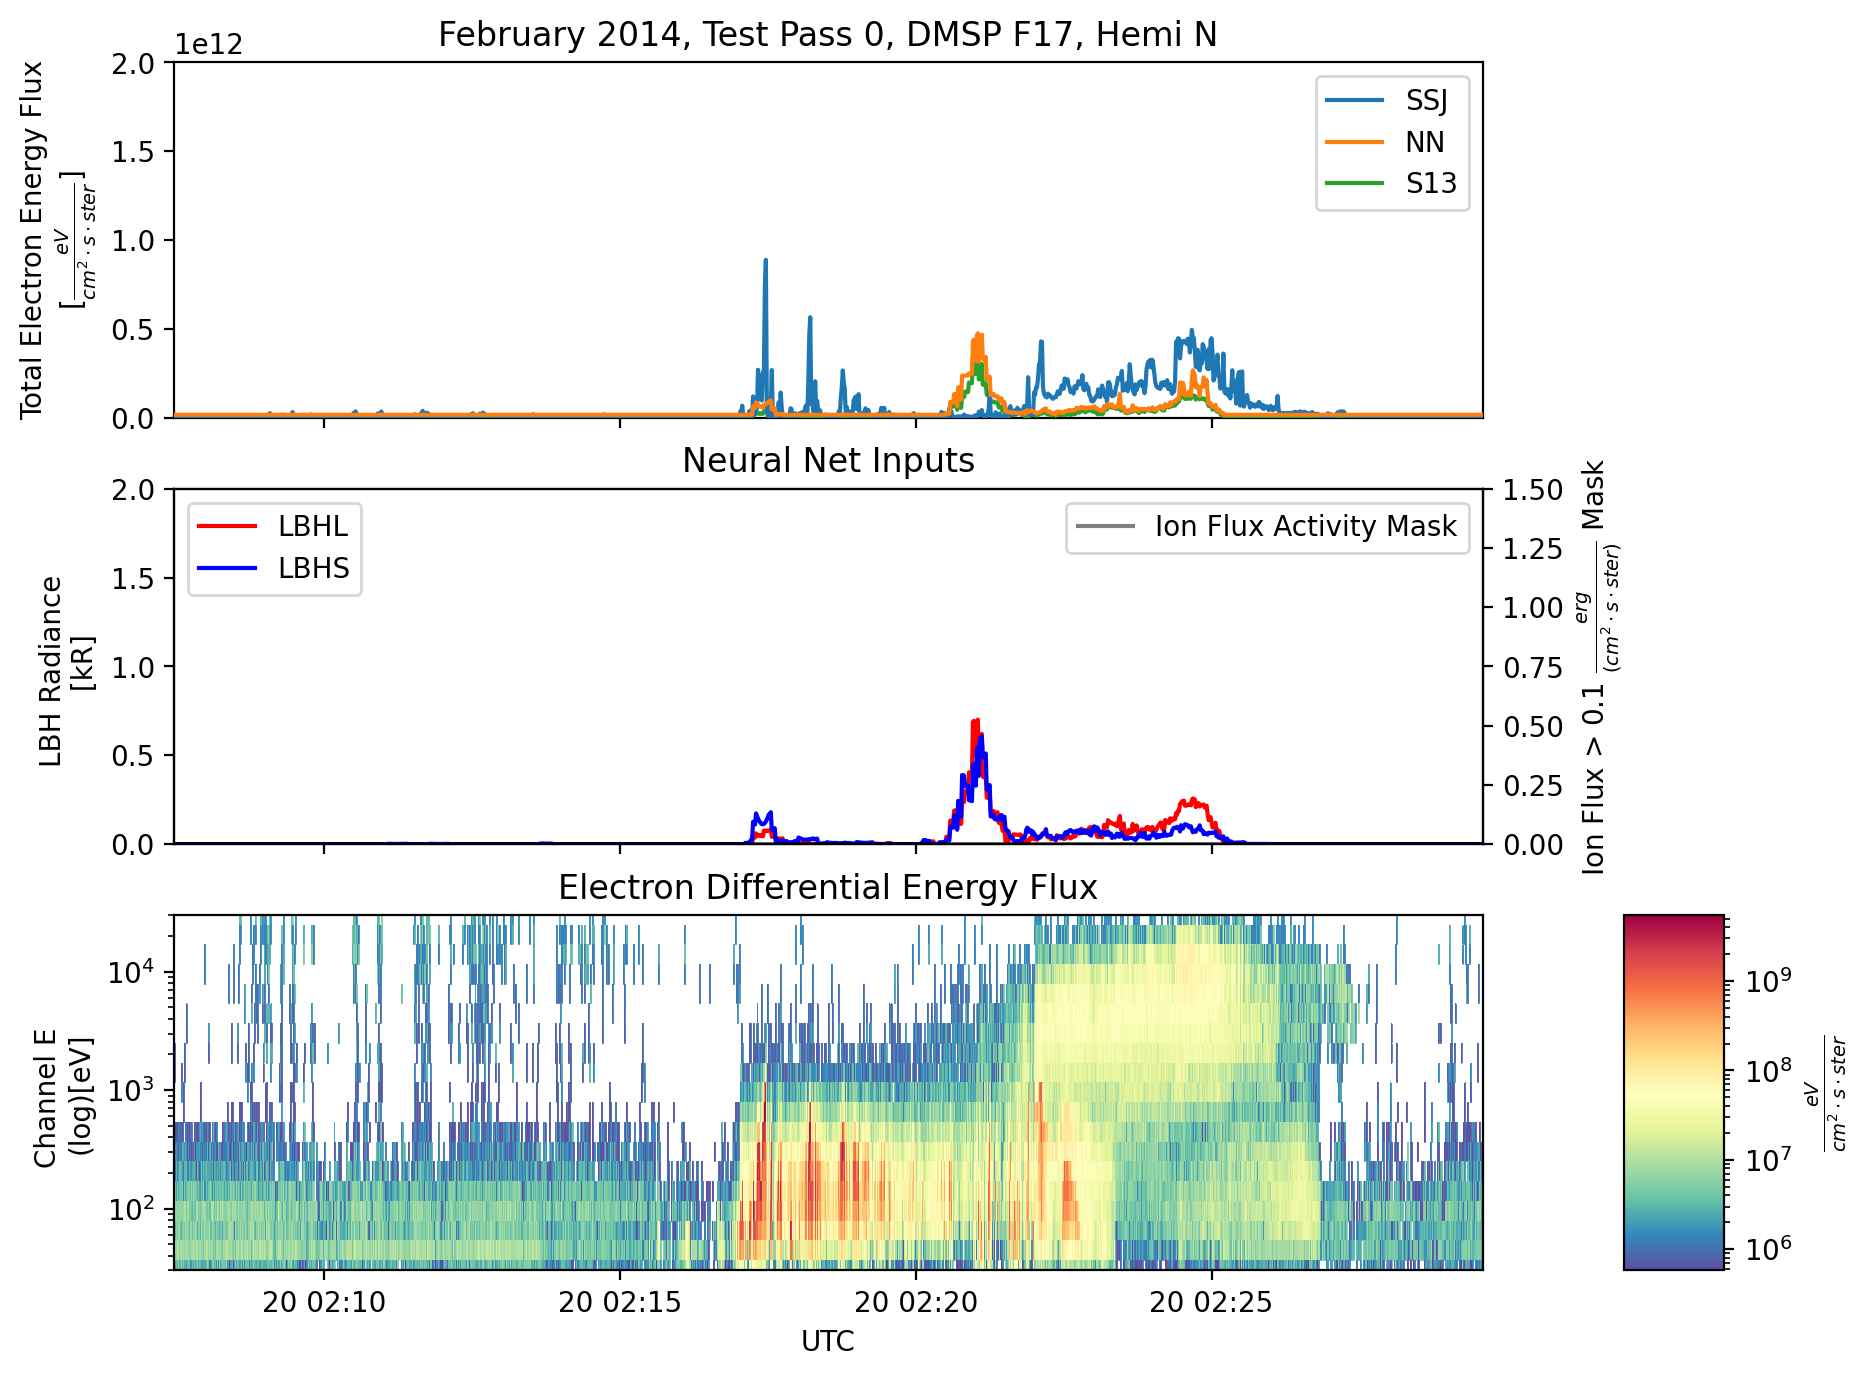

277.0
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)
(1242,)


/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:111: RuntimeWarning: invalid value encountered in less
  inds = np.nonzero((~np.isfinite(flux)) | (flux < 0.))
/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:126: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
  cmap.set_bad('white',.1)
/home/matsuo/amgeo_dev/Pseudo_ML/ssj_auroral_boundary/ssj_auroral_boundary/dmsp_spectrogram.py:127: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap(

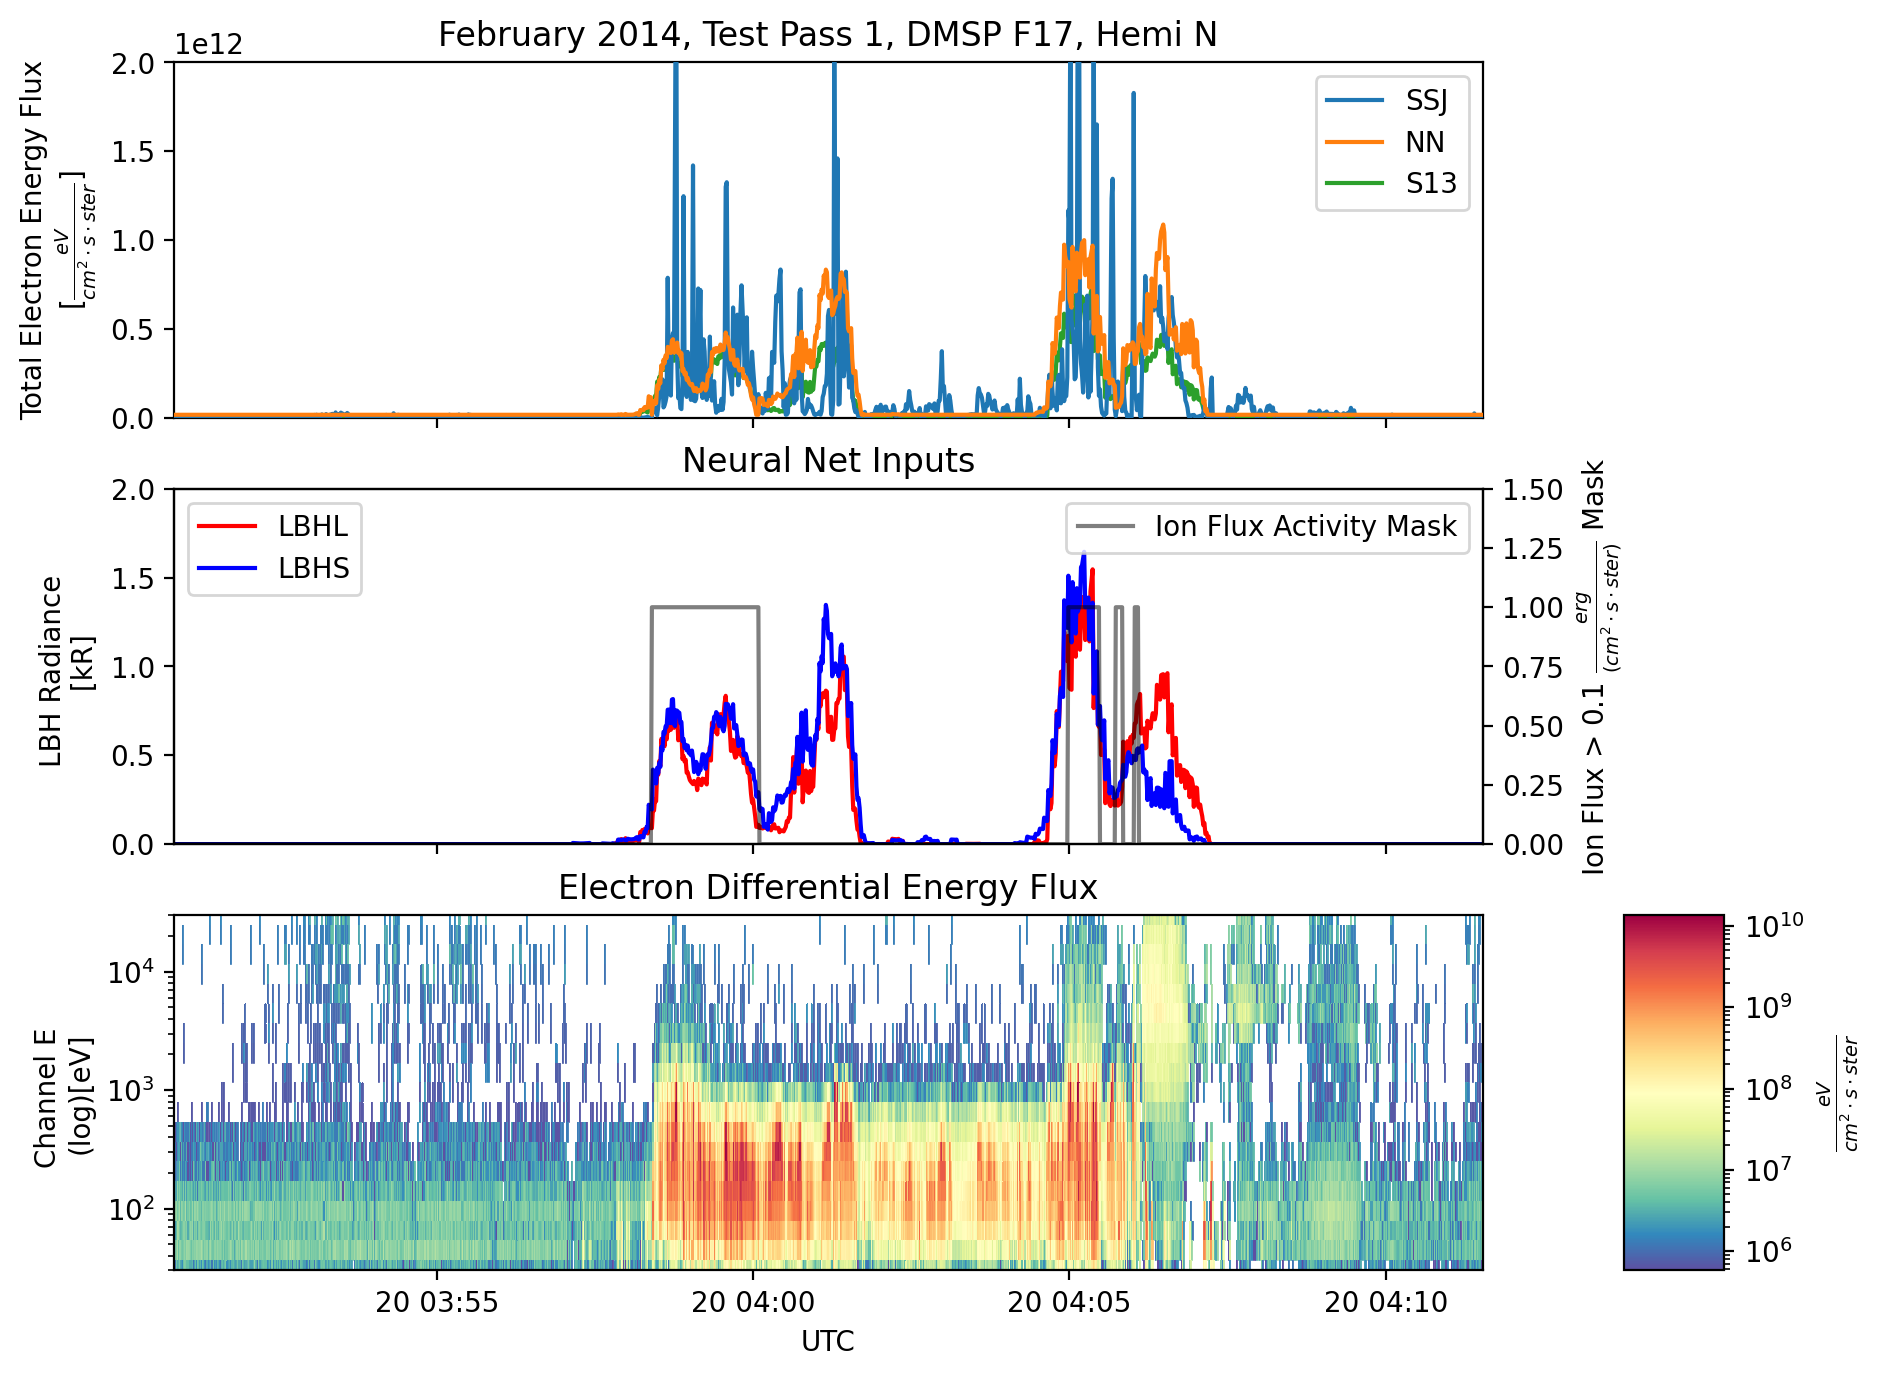

In [13]:
%matplotlib inline
# plot a couple of passes to show off
i = 0

#iterate across the test passes
for test_pass in test_pass_nums[33:35]:
    print(test_pass)
    test_pass_mask = test_pass == test_passes
    y_predict_pass, y_test_pass, jd_pass = y_predict[test_pass_mask], y_test[test_pass_mask], jd_test[test_pass_mask]
    
    sat_nums_pass = sat_nums_test[test_pass_mask]
    lats_pass = lats_test[test_pass_mask]
    dmsp = sat_nums_pass[0]
    if (np.nanmedian(lats_pass)) > 0:
        hemi = 'N'
    else:
        hemi = 'S'
    
    #get the inputs
    X_test_pass = X_test[test_pass_mask]
    X_test_pass = X_test_pass
    lbhl_pass, lbhs_pass = X_test_pass[:,0], X_test_pass[:,1]
    ion_more_ele_pass = X_test_pass[:,2]
    
    y_predict_pass = y_predict_pass
    y_test_pass = y_test_pass
    
    ele_diff_energy_flux_test_pass = ele_diff_energy_flux_test[test_pass_mask.flatten(),:]
    
    f1 = pp.figure(figsize=(10,10*0.8),dpi=200)
    gs = GridSpec(3,13)
    a1  = f1.add_subplot(gs[0,0:11])
    a1.plot(jdarr2datetime(jd_pass), y_test_pass[:,0], label = 'SSJ', zorder = 10)
    a1.plot(jdarr2datetime(jd_pass), y_predict_pass[:,0], label = 'NN', zorder = 10)
    a1.plot(jdarr2datetime(jd_pass), lbhl_pass * 4.9e8 * 1000, label = 'S13' , zorder = 5)
    
    a1.set(title = 'February 2014, Test Pass {}, DMSP F{}, Hemi {}'.format(i, int(dmsp), hemi), \
           ylabel = r'Total Electron Energy Flux' + '\n' + r'[$\frac{eV}{cm^2 \cdot s \cdot ster}$]',\
           xlim = [np.nanmin(jdarr2datetime(jd_pass)),np.nanmax(jdarr2datetime(jd_pass))], \
           ylim = [0,2e12])
    a1.set_xticklabels([])
    a1.legend()
    
    a3  = f1.add_subplot(gs[1,0:11])
    a3.plot(jdarr2datetime(jd_pass), lbhl_pass, label = 'LBHL', c = 'r')
    a3.plot(jdarr2datetime(jd_pass), lbhs_pass, label = 'LBHS', c = 'b')
    a3.set(title = 'Neural Net Inputs',ylabel ='LBH Radiance \n [kR]', xlim = [np.nanmin(jdarr2datetime(jd_pass)),np.nanmax(jdarr2datetime(jd_pass))], ylim = [0,2])
    a3.legend(loc = 'upper left')
    a3_twin = a3.twinx()
    a3_twin.set_ylabel(r'Ion Flux > 0.1 $\frac{erg}{(cm^2 \cdot s \cdot ster)}$ Mask')
    a3_twin.set_ylim([0,1.5])
    a3_twin.plot(jdarr2datetime(jd_pass), ion_more_ele_pass, label = 'Ion Flux Activity Mask',c = 'k', alpha = 0.5)
    a3_twin.legend(loc = 'upper right')
    a3.set_xticklabels([])
    
    a2  = f1.add_subplot(gs[2,0:11])
    a2cb = f1.add_subplot(gs[2,12])
    dmsp_spectrogram(jdarr2datetime(jd_pass), ele_diff_energy_flux_test_pass, \
          channel_energies = None, ax = a2, ax_cb = a2cb, label_it = False, fluxunits = r'$\frac{eV}{cm^2 \cdot s \cdot ster}$')    
    a2.set(title = 'Electron Differential Energy Flux', xlim = [np.nanmin(jdarr2datetime(jd_pass)),np.nanmax(jdarr2datetime(jd_pass))])
    a2.set( xlabel = 'UTC')
    pp.show()
    i+=1
